# Cars

In [249]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

import tsensor

dtype = torch.double

In [250]:
tsensor.__version__

'0.1b7'

In [255]:
df_cars = pd.read_csv("../data/cars.csv")
df_cars.head(2)

,MPG,CYL,ENG,WGT
0,18.0,8,307.0,3504
1,15.0,8,350.0,3693


In [257]:
n = len(df_cars)
X = torch.tensor(df_cars.WGT).float().reshape(n,1)
X = (X-torch.mean(X))/torch.std(X)
y = torch.tensor(df_cars.MPG).reshape(n,1)

## Built-in Linear model with pytorch

Epoch   0 MSE loss      654.943 MAE    24.11
Epoch  10 MSE loss      224.501 MAE    14.30
Epoch  20 MSE loss       54.251 MAE     6.10
Epoch  30 MSE loss       19.708 MAE     3.33
Epoch  40 MSE loss       23.587 MAE     3.96
Epoch  50 MSE loss       22.095 MAE     3.77
Epoch  60 MSE loss       19.022 MAE     3.35
Epoch  70 MSE loss       18.766 MAE     3.27
LAST      MSE loss       18.766 MAE     3.27


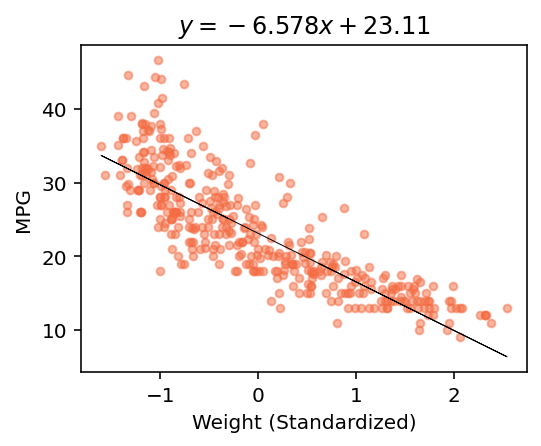

In [258]:
model = nn.Linear(1, 1) # each instance has 1 value, spit out 1 value

learning_rate = 1
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
nepochs=70
for epoch in range(nepochs+1):
    with tsensor.clarify():
        y_pred = model(X)
    loss = torch.mean((y_pred - y)**2)
    if epoch % 10 == 0:
        with torch.no_grad():
            mae = torch.mean(torch.abs(y_pred - y))
            print(f"Epoch {epoch:3d} MSE loss {loss:12.3f} MAE {mae:8.2f}")

    # Backprop to compute gradients
    optimizer.zero_grad()
    loss.backward()
    optimizer.step() # adjust weights
    
m = model.weight.detach().item()
b = model.bias.detach().item()
print(f"LAST      MSE loss {loss:12.3f} MAE {mae:8.2f}")

carshow(m, b, X=X, y=df_cars.MPG)

## Sequence of 2 linear models with pytorch

Unless we add relu or sigmoid, 2 models chained is same as one: it's a line.

Let's create a generic training function for given model and a new show function.

In [259]:
def mshow(model, X=df_cars.WGT, y=df_cars.MPG, file=None):
    fig, ax = plt.subplots(figsize=(4,3))

    with torch.no_grad():
        y_pred = model(X)
    ax.scatter(X, y, s=15, color='#F46C43', alpha=.5)
    ax.scatter(X, y_pred, lw=.5, color='black', s=1)
    if sum(X)/len(X)<1.0:
        ax.set_xlabel("Weight (Standardized)")
    else:
        ax.set_xlabel("Weight")
    ax.set_ylabel("MPG")
    plt.tight_layout()
    if file:
        plt.savefig(f"/Users/parrt/Desktop/{file}.pdf")
    plt.show()

In [260]:
def train(model, learning_rate = .5, nepochs=2000):
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    for epoch in range(nepochs+1):
        y_pred = model(X)
        loss = torch.mean((y_pred - y)**2)
        if epoch % (nepochs//10) == 0:
            with torch.no_grad():
                mae = torch.mean(torch.abs(y_pred - y))
                print(f"Epoch {epoch:4d} MSE loss {loss:12.3f} MAE {mae:8.2f}")

        optimizer.zero_grad()
        loss.backward() # autograd computes w1.grad, b1.grad, ...
        optimizer.step()
    print(f"LAST       MSE loss {loss:12.3f} MAE {mae:8.2f}")
    return loss

### Without nonlinearity

Epoch    0 MSE loss      606.858 MAE    23.47
Epoch   10 MSE loss       80.686 MAE     7.22
Epoch   20 MSE loss       29.763 MAE     4.52
Epoch   30 MSE loss       22.044 MAE     3.75
Epoch   40 MSE loss       18.904 MAE     3.25
Epoch   50 MSE loss       18.746 MAE     3.26
Epoch   60 MSE loss       18.846 MAE     3.34
Epoch   70 MSE loss       18.763 MAE     3.25
Epoch   80 MSE loss       18.704 MAE     3.30
Epoch   90 MSE loss       18.681 MAE     3.27
Epoch  100 MSE loss       18.677 MAE     3.28
LAST       MSE loss       18.677 MAE     3.28


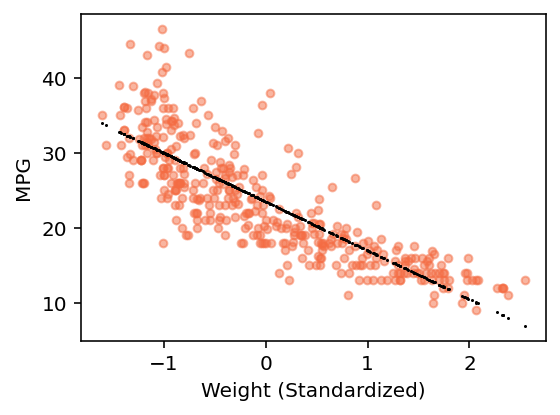

In [261]:
model = nn.Sequential(
    nn.Linear(1, 1), # each instance has 1 value, spit out 1 values
    nn.Linear(1, 1)
)

train(model, learning_rate=2.1, nepochs=100)

mshow(model, X=X, y=df_cars.MPG, file="2linear")

### With ReLU nonlinearity

Epoch    0 MSE loss      573.597 MAE    22.49
Epoch   10 MSE loss       21.207 MAE     3.59
Epoch   20 MSE loss       19.648 MAE     3.25
Epoch   30 MSE loss       20.568 MAE     3.33
Epoch   40 MSE loss       20.180 MAE     3.29
Epoch   50 MSE loss       18.800 MAE     3.21
Epoch   60 MSE loss       18.542 MAE     3.28
Epoch   70 MSE loss       18.259 MAE     3.18
Epoch   80 MSE loss       18.094 MAE     3.20
Epoch   90 MSE loss       17.972 MAE     3.17
Epoch  100 MSE loss       17.894 MAE     3.16
LAST       MSE loss       17.894 MAE     3.16


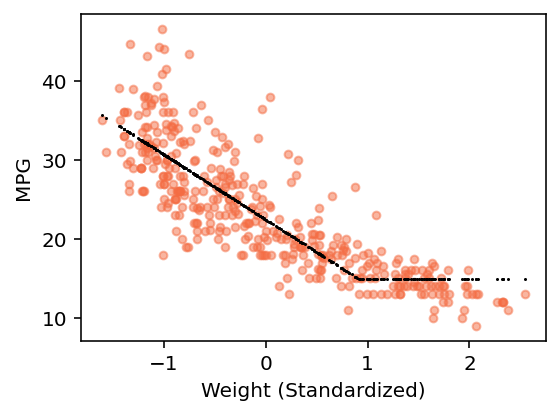

In [262]:
model = nn.Sequential(
    nn.Linear(1, 1), # each instance has 1 value, spit out 1 values
    nn.ReLU(),     # add nonlinearity, gives two lines
    nn.Linear(1, 1)
)

train(model, learning_rate=2.1, nepochs=100)

mshow(model, X=X, y=df_cars.MPG, file="linRlin")

Epoch    0 MSE loss      627.675 MAE    23.73
Epoch   10 MSE loss       72.381 MAE     7.45
Epoch   20 MSE loss       23.770 MAE     4.06
Epoch   30 MSE loss       23.114 MAE     3.88
Epoch   40 MSE loss       18.803 MAE     3.19
Epoch   50 MSE loss       18.357 MAE     3.13
Epoch   60 MSE loss       17.718 MAE     3.12
Epoch   70 MSE loss       17.674 MAE     3.14
Epoch   80 MSE loss       17.673 MAE     3.14
Epoch   90 MSE loss       17.635 MAE     3.13
Epoch  100 MSE loss       17.605 MAE     3.12
LAST       MSE loss       17.605 MAE     3.12


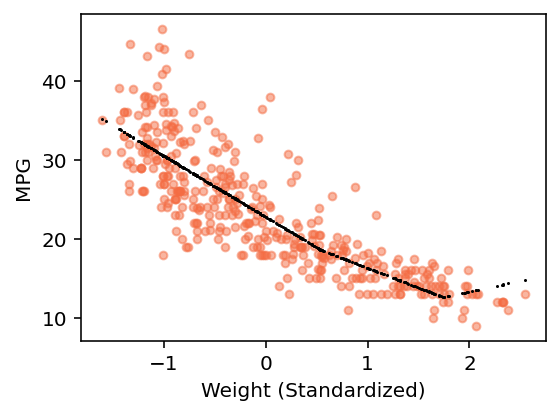

In [263]:
model = nn.Sequential(
    nn.Linear(1, 5),
    nn.ReLU(),
    nn.Linear(5, 1)
)

train(model, learning_rate=1, nepochs=100)

mshow(model, X=X, y=df_cars.MPG, file="lin5Rlin")

Epoch    0 MSE loss      579.123 MAE    22.77
Epoch   10 MSE loss      140.791 MAE    11.04
Epoch   20 MSE loss       30.165 MAE     4.16
Epoch   30 MSE loss       36.201 MAE     4.37
Epoch   40 MSE loss       24.248 MAE     4.00
Epoch   50 MSE loss       20.347 MAE     3.31
Epoch   60 MSE loss       18.419 MAE     3.23
Epoch   70 MSE loss       17.792 MAE     3.06
Epoch   80 MSE loss       17.510 MAE     3.11
Epoch   90 MSE loss       17.446 MAE     3.06
Epoch  100 MSE loss       17.411 MAE     3.06
LAST       MSE loss       17.411 MAE     3.06


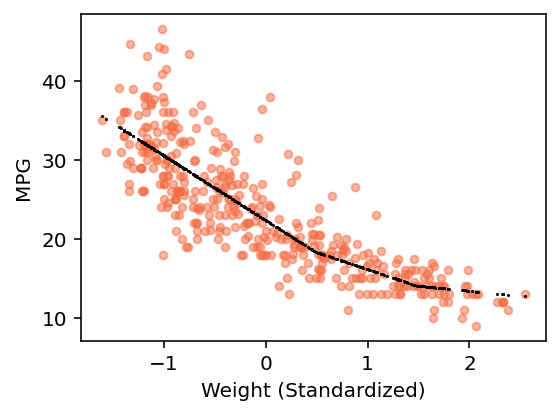

In [264]:
model = nn.Sequential(
    nn.Linear(1, 5),
    nn.ReLU(),
    nn.Linear(5, 2),
    nn.ReLU(),
    nn.Linear(2, 1)
)

train(model, learning_rate=.1, nepochs=100)

mshow(model, X=X, y=df_cars.MPG, file="lin5Rlin2")

### Show shape of matrix algebra

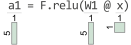

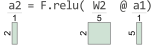

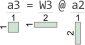

In [265]:
# Draw matrix shapes
import torch.nn.functional as F
import tsensor

W1 = torch.rand(5,1)
W2 = torch.rand(2,5)
W3 = torch.rand(1,2)
x = torch.rand(1,1)
with tsensor.explain() as e:
    a1 = F.relu(W1 @ x)
    a2 = F.relu(W2 @ a1)
    a3 = W3 @ a2
e.views[0].savefig(filename="/Users/parrt/Desktop/a1.svg")
e.views[1].savefig(filename="/Users/parrt/Desktop/a2.svg")
e.views[2].savefig(filename="/Users/parrt/Desktop/a3.svg")

### With tanh nonlinearity

Epoch    0 MSE loss      636.478 MAE    24.01
Epoch   10 MSE loss       34.969 MAE     4.68
Epoch   20 MSE loss       63.033 MAE     6.39
Epoch   30 MSE loss       31.779 MAE     4.61
Epoch   40 MSE loss       31.396 MAE     4.34
Epoch   50 MSE loss       27.265 MAE     4.08
Epoch   60 MSE loss       26.817 MAE     4.03
Epoch   70 MSE loss       26.654 MAE     3.99
Epoch   80 MSE loss       26.405 MAE     4.00
Epoch   90 MSE loss       26.426 MAE     4.01
Epoch  100 MSE loss       26.380 MAE     3.99
LAST       MSE loss       26.380 MAE     3.99


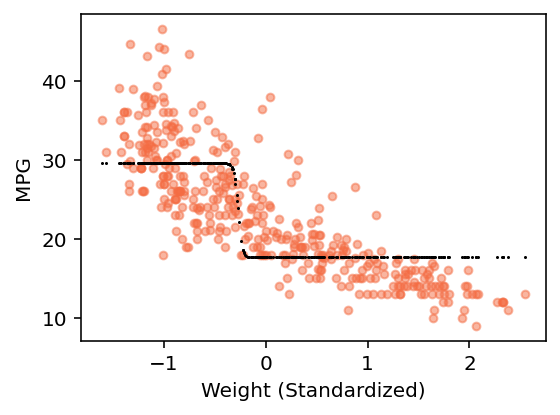

In [266]:
model = nn.Sequential(
    nn.Linear(1, 1), # each instance has 1 value, spit out 1 values
    nn.Tanh(),       # gives smooth step function shape
    nn.Linear(1, 1)
)

train(model, learning_rate=2.1, nepochs=100)

mshow(model, X=X, y=df_cars.MPG, file="linTlin")

### With logistic function (sigmoid) nonlinearity

Epoch    0 MSE loss      651.513 MAE    24.33
Epoch   10 MSE loss      130.299 MAE     9.74
Epoch   20 MSE loss       80.977 MAE     7.64
Epoch   30 MSE loss       61.960 MAE     6.66
Epoch   40 MSE loss       62.503 MAE     6.53
Epoch   50 MSE loss       61.360 MAE     6.52
Epoch   60 MSE loss       61.178 MAE     6.59
Epoch   70 MSE loss       60.797 MAE     6.54
Epoch   80 MSE loss       60.763 MAE     6.55
Epoch   90 MSE loss       60.763 MAE     6.55
Epoch  100 MSE loss       60.763 MAE     6.55
LAST       MSE loss       60.763 MAE     6.55


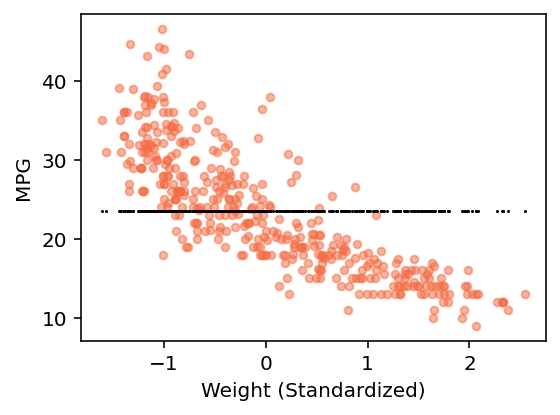

In [267]:
model = nn.Sequential(
    nn.Linear(1, 1), # each instance has 1 value, spit out 1 values
    nn.Sigmoid(),    # doesn't converge as fast; bump learning rate
    nn.Linear(1, 1)
)

train(model, learning_rate=35, nepochs=100)

mshow(model, X=X, y=df_cars.MPG, file='linSlin')

## Overfitting with a two-layer pytorch network

Epoch    0 MSE loss      614.844 MAE    23.37
Epoch  200 MSE loss       17.155 MAE     3.04
Epoch  400 MSE loss       16.967 MAE     3.03
Epoch  600 MSE loss       16.740 MAE     3.02
Epoch  800 MSE loss       16.591 MAE     3.01
Epoch 1000 MSE loss       16.563 MAE     3.00
Epoch 1200 MSE loss       16.610 MAE     3.03
Epoch 1400 MSE loss       16.629 MAE     2.97
Epoch 1600 MSE loss       16.568 MAE     2.97
Epoch 1800 MSE loss       16.527 MAE     2.98
Epoch 2000 MSE loss       16.533 MAE     3.00
LAST       MSE loss       16.533 MAE     3.00


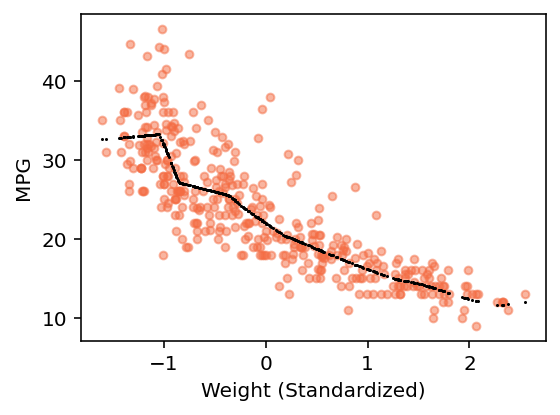

In [268]:
model = nn.Sequential(
    nn.Linear(1, 1000), # each instance has 1 value, spit out 1000 values
    nn.ReLU(),          # fast to compute, not smooth y_pred
    nn.Linear(1000, 1)
)

train(model, learning_rate=.1)

mshow(model, X=X, y=df_cars.MPG, file="lin1kRlin")

Epoch    0 MSE loss      602.494 MAE    23.33
Epoch  150 MSE loss       17.315 MAE     3.05
Epoch  300 MSE loss       17.287 MAE     3.06
Epoch  450 MSE loss       17.263 MAE     3.05
Epoch  600 MSE loss       17.247 MAE     3.05
Epoch  750 MSE loss       17.269 MAE     3.07
Epoch  900 MSE loss       17.080 MAE     3.03
Epoch 1050 MSE loss       16.936 MAE     3.00
Epoch 1200 MSE loss       16.830 MAE     3.00
Epoch 1350 MSE loss       16.760 MAE     2.99
Epoch 1500 MSE loss       16.707 MAE     2.99
LAST       MSE loss       16.707 MAE     2.99


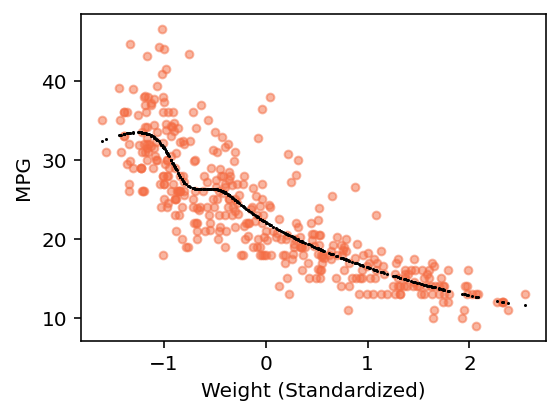

In [269]:
model = nn.Sequential(
    nn.Linear(1, 1000), # each instance has 1 value, spit out 1000 values
    nn.Tanh(),          # add nonlinearity
    nn.Linear(1000, 1)
)

train(model, learning_rate=.1, nepochs=1500)

mshow(model, X=X, y=df_cars.MPG)